In [ ]:
# Importação das bibliotecas necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [5]:
# Carregar o arquivo CSV
file_path = 'train3.csv'  # Caminho do arquivo
data = pd.read_csv(file_path)

# Pré-processamento
data['Date'] = pd.to_datetime(data['Date']) # Converter a coluna Date para datetime
data['Year'] = data['Date'].dt.year         # Adicionar coluna de ano
data['Month'] = data['Date'].dt.month       # Adicionar coluna de mês
data['Day'] = data['Date'].dt.day           # Adicionar coluna de dia

# Ordenar os dados por departamento e data
data = data.sort_values(by=['Dept', 'Year', 'Month', 'Day'])

In [6]:
# Criar features baseadas em vendas passadas
data['Prev_Week_Sales'] = data.groupby('Dept')['Weekly_Sales'].shift(1)
data['MA_2_Weeks'] = data.groupby('Dept')['Weekly_Sales'].shift(1).rolling(window=2).mean()
data['MA_4_Weeks'] = data.groupby('Dept')['Weekly_Sales'].shift(1).rolling(window=4).mean()

In [7]:
# Remover as linhas iniciais que ficaram com NaN
data = data.dropna()

# Converter 'IsHoliday' em dummies
data = pd.get_dummies(data, columns=['IsHoliday'], drop_first=True)

# Separar treino (dados até 2011) e teste (dados de 2012)
train_data = data[data['Year'] < 2012]
test_data = data[data['Year'] == 2012]

In [8]:
# Separar features e alvo
features = ['Store', 'Dept', 'IsHoliday_True', 'Prev_Week_Sales', 'MA_2_Weeks', 'MA_4_Weeks']
X_train = train_data[features]
y_train = train_data['Weekly_Sales']
X_test = test_data[features]
y_test = test_data['Weekly_Sales']

# Treinar o modelo Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

RandomForestRegressor(n_jobs=-1, random_state=42)

In [9]:
# Fazer previsões no conjunto de teste
y_pred = rf_model.predict(X_test)

# Avaliar o modelo
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f"Erro Médio Quadrático Raiz (RMSE): {rmse:.2f}")

# Adicionar previsões ao conjunto de teste para análise
test_results = test_data.copy()
test_results['Predicted_Weekly_Sales'] = y_pred


Erro Médio Quadrático Raiz (RMSE): 4178.68


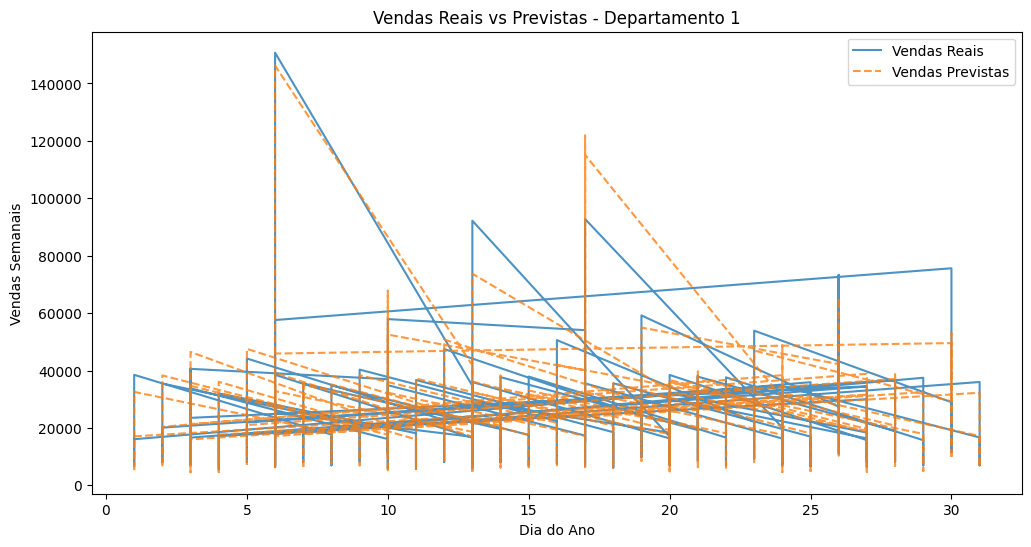

In [10]:
# Gráficos
# Gráfico 1: Linhas detalhadas para um único departamento
dept_to_plot = 1
dept_data_rf = test_results[test_results['Dept'] == dept_to_plot]

plt.figure(figsize=(12, 6))
plt.plot(dept_data_rf['Day'], dept_data_rf['Weekly_Sales'], label='Vendas Reais', alpha=0.8)
plt.plot(dept_data_rf['Day'], dept_data_rf['Predicted_Weekly_Sales'], linestyle='--', label='Vendas Previstas', alpha=0.8)
plt.title(f"Vendas Reais vs Previstas - Departamento {dept_to_plot}")
plt.xlabel("Dia do Ano")
plt.ylabel("Vendas Semanais")
plt.legend()
plt.show()

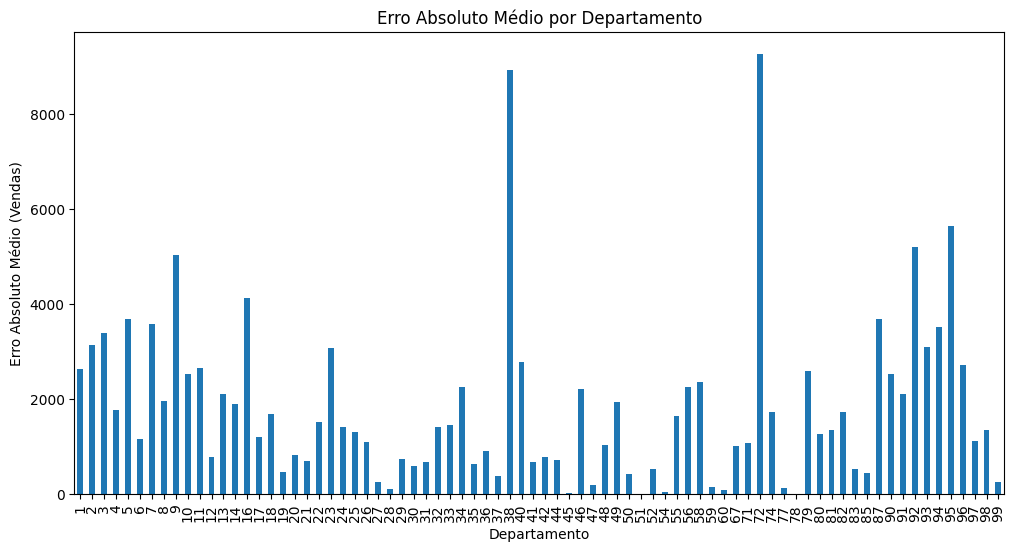

In [11]:
# Gráfico 2: Erro Absoluto Médio por Departamento
test_results['Absolute_Error'] = abs(test_results['Weekly_Sales'] - test_results['Predicted_Weekly_Sales'])
mean_absolute_error_by_dept = test_results.groupby('Dept')['Absolute_Error'].mean()

mean_absolute_error_by_dept.plot(kind='bar', figsize=(12, 6))
plt.title("Erro Absoluto Médio por Departamento")
plt.xlabel("Departamento")
plt.ylabel("Erro Absoluto Médio (Vendas)")
plt.show()

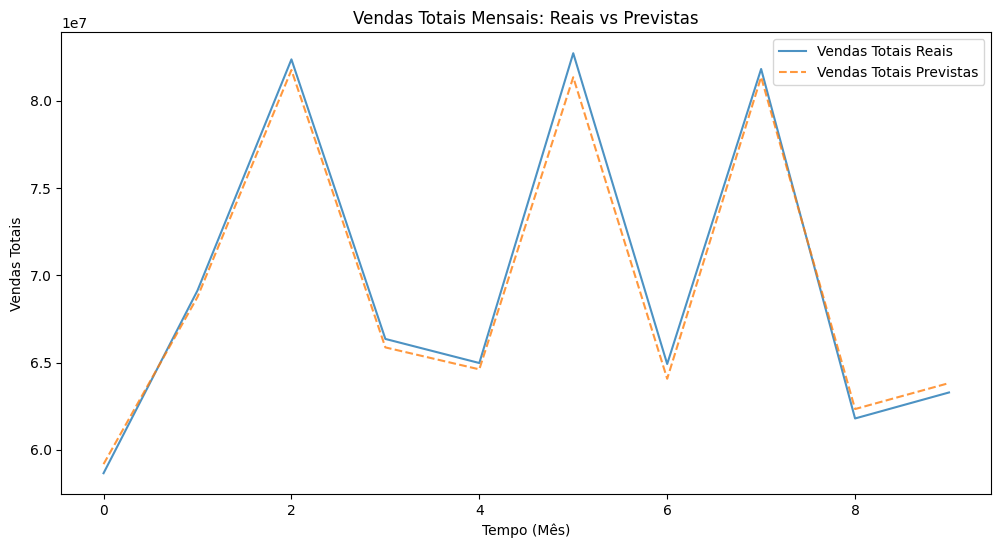

In [12]:
# Gráfico 3: Vendas Totais Reais vs Previstas ao longo do tempo
totals_over_time = test_results.groupby(['Year', 'Month']).agg({
    'Weekly_Sales': 'sum',
    'Predicted_Weekly_Sales': 'sum'
}).reset_index()

plt.figure(figsize=(12, 6))
plt.plot(totals_over_time.index, totals_over_time['Weekly_Sales'], label='Vendas Totais Reais', alpha=0.8)
plt.plot(totals_over_time.index, totals_over_time['Predicted_Weekly_Sales'], linestyle='--', label='Vendas Totais Previstas', alpha=0.8)
plt.title("Vendas Totais Mensais: Reais vs Previstas")
plt.xlabel("Tempo (Mês)")
plt.ylabel("Vendas Totais")
plt.legend()
plt.show()

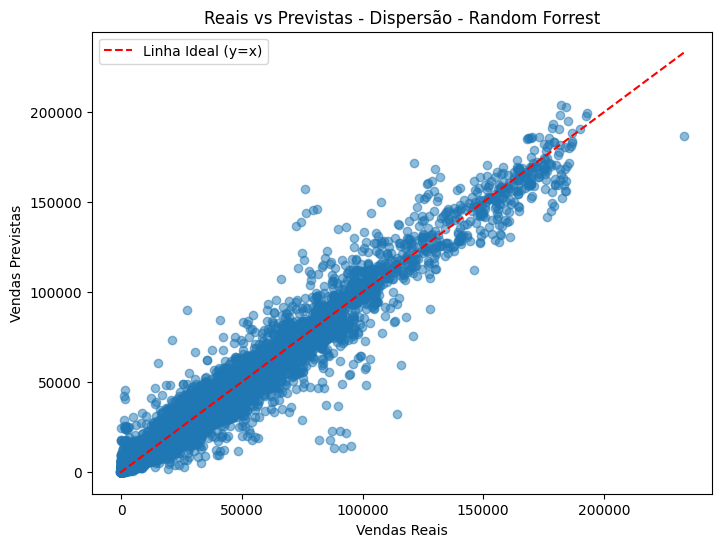

In [13]:
# Gráfico 4: Scatter Plot - Reais vs Previstas
plt.figure(figsize=(8, 6))
plt.scatter(test_results['Weekly_Sales'], test_results['Predicted_Weekly_Sales'], alpha=0.5)
plt.plot([test_results['Weekly_Sales'].min(), test_results['Weekly_Sales'].max()],
         [test_results['Weekly_Sales'].min(), test_results['Weekly_Sales'].max()],
         color='red', linestyle='--', label='Linha Ideal (y=x)')
plt.title("Reais vs Previstas - Dispersão - Random Forrest")
plt.xlabel("Vendas Reais")
plt.ylabel("Vendas Previstas")
plt.legend()
plt.show()